<a href="https://colab.research.google.com/github/Akashnawin/Mainframe-ML-Capstone/blob/main/Mainframe_ML_Model_for_Message_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION 1 — Setup & Install Dependencies

In [1]:
!pip install -q firebase-admin pandas scikit-learn matplotlib seaborn wordcloud joblib

# SECTION 2 — Imports

In [2]:
import os, time, math, itertools, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib

import firebase_admin
from firebase_admin import credentials, firestore, storage

sns.set_style("darkgrid")

# SECTION 3 — Connect to Firebase

In [4]:
# Upload your service account JSON into Colab files pane and set the filename below
SERVICE_KEY = "mainframe-firebase-integration-firebase-adminsdk-fbsvc-d08d5a8675.json"   # <-- change if your key filename differs

if not os.path.exists(SERVICE_KEY):
    raise SystemExit(f"Service key not found. Upload {SERVICE_KEY} in the Colab Files pane.")

cred = credentials.Certificate(SERVICE_KEY)
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred)
db = firestore.client()
print("Connected to Firestore ✓")


Connected to Firestore ✓


# SECTION 4 — Load messages from Firestore

In [5]:
COLLECTION = "tbl_msg"   # change if you used a different collection name

def fetch_collection_to_df(collection_name):
    docs = db.collection(collection_name).stream()
    rows = []
    for d in docs:
        rec = d.to_dict()
        # keep the doc id for reliable updates
        rec["_docid"] = d.id
        rows.append(rec)
    df_local = pd.DataFrame(rows)
    return df_local

df = fetch_collection_to_df(COLLECTION)
print("Fetched rows:", len(df))
display(df.head(8))

Fetched rows: 800


,MSGID,TIMESTMP,USERID,LABEL,JOBNAME,TEXT,SEQNO,SYSID,_docid
0,IEF403I,09.50.16,OPSS,normal,USER325,-WTO2,1,MVSF,1
1,EZZ6034I,09.25.54,USER325M,normal,USER325M,-WTO2,10,MVSF,10
2,PMO396I,09.03.43,SYSOP,normal,OPSS,-WTO1,100,MVSF,100
3,PREFIX,09.00.50,SYSOP,normal,JES2,-WTOR2,101,MVSF,101
4,IEF403I,09.58.49,START1,normal,CONSOLE,-WTO1,102,MVSF,102
5,PMO388I,09.10.11,SYSOP,normal,USER325,OPS TRAINING: NORMAL MSG 2 - JUST CHECKING IN,103,MVSF,103
6,PREFIX,09.38.05,START1,normal,OPSS,-WTO3,104,MVSF,104
7,DBSERR01,09.30.13,USER325M,critical,USER325M,ERROR: Job STEP1 ABEND RC=16 - URGENT,105,MVSF,105


# SECTION 5 — Basic cleanup and ensure TEXT exists

In [6]:
# Normalise column names to upper (makes later code stable)
df.columns = [c.upper() for c in df.columns]

# Attempt to find TEXT column under common names
if 'TEXT' not in df.columns:
    if 'OTEXT' in df.columns: df['TEXT'] = df['OTEXT']
    else:
        # try any column that contains 'TEXT' substring
        for col in df.columns:
            if 'TEXT' in col:
                df['TEXT'] = df[col]
                break

df['TEXT'] = df['TEXT'].fillna('').astype(str).str.strip()

# Ensure SEQNO as string for doc id mapping if present
if 'SEQNO' in df.columns:
    df['SEQNO'] = df['SEQNO'].astype(str)

print("Columns:", df.columns.tolist())
print("Sample TEXTs:")
for t in df['TEXT'].head(6):
    print(" -", t[:120])

Columns: ['MSGID', 'TIMESTMP', 'USERID', 'LABEL', 'JOBNAME', 'TEXT', 'SEQNO', 'SYSID', '_DOCID']
Sample TEXTs:
 - -WTO2
 - -WTO2
 - -WTO1
 - -WTOR2
 - -WTO1
 - OPS TRAINING: NORMAL MSG 2 - JUST CHECKING IN


# SECTION 6 — Create LABEL column if not present (heuristic bootstrap)

In [7]:
# If dataset already has LABEL column, use it; otherwise create one via keywords
if 'LABEL' in df.columns and df['LABEL'].notna().sum() > 0:
    df['LABEL'] = df['LABEL'].astype(str).str.lower()
    print("Using existing LABEL column (found).")
else:
    print("No LABEL column found - creating heuristic LABEL.")
    critical_kw = [
        'CRIT', 'CRITICAL', 'FAIL', 'FAILED', 'ERROR', 'URGENT', 'DOWN',
        'EXCEPTION', 'PANIC', 'RESTART', 'ABEND', 'SEVERE', 'PROBLEM',
        'OUTAGE', 'UNAVAILABLE', 'CRASH', 'EMERGENCY', 'ALERT', 'ABEND'
    ]
    pattern = re.compile(r'(' + '|'.join([re.escape(w) for w in critical_kw]) + r')', flags=re.I)

    def heuristic_label(text):
        if pattern.search(text or ''):
            return 'critical'
        return 'normal'

    df['LABEL'] = df['TEXT'].apply(heuristic_label)

print("Label counts:\n", df['LABEL'].value_counts())

Using existing LABEL column (found).
Label counts:
 LABEL
normal      651
critical    149
Name: count, dtype: int64


# SECTION 7 — Train / Test split & model training

In [8]:
# Split - stratify on LABEL
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['LABEL'], random_state=42)
print("Train / Test sizes:", len(train_df), len(test_df))

# TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train = tfidf.fit_transform(train_df['TEXT'])
y_train = train_df['LABEL']

clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=42)
clf.fit(X_train, y_train)

X_test = tfidf.transform(test_df['TEXT'])
y_test = test_df['LABEL']
y_pred = clf.predict(X_test)

print("Classification report (test set):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Train / Test sizes: 640 160
Classification report (test set):
              precision    recall  f1-score   support

    critical       1.00      1.00      1.00        30
      normal       1.00      1.00      1.00       130

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Confusion matrix:
[[ 30   0]
 [  0 130]]


# SECTION 8 — Save model & vectorizer

In [9]:
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(clf, "msg_clf_logreg.joblib")
print("Saved tfidf_vectorizer.joblib and msg_clf_logreg.joblib")

Saved tfidf_vectorizer.joblib and msg_clf_logreg.joblib


# SECTION 9 — Predict entire collection and prepare results

In [10]:
X_all = tfidf.transform(df['TEXT'])
df['PRED_LABEL'] = clf.predict(X_all)
if hasattr(clf, "predict_proba"):
    prob_idx = list(clf.classes_).index('critical') if 'critical' in clf.classes_ else 0
    df['PRED_PROB_CRITICAL'] = clf.predict_proba(X_all)[:, prob_idx]
else:
    df['PRED_PROB_CRITICAL'] = 0.0

print("Pred counts:", df['PRED_LABEL'].value_counts().to_dict())
display(df[['SEQNO','_DOCID','TEXT','LABEL','PRED_LABEL']].head(8))

Pred counts: {'normal': 651, 'critical': 149}


,SEQNO,_DOCID,TEXT,LABEL,PRED_LABEL
0,1,1,-WTO2,normal,normal
1,10,10,-WTO2,normal,normal
2,100,100,-WTO1,normal,normal
3,101,101,-WTOR2,normal,normal
4,102,102,-WTO1,normal,normal
5,103,103,OPS TRAINING: NORMAL MSG 2 - JUST CHECKING IN,normal,normal
6,104,104,-WTO3,normal,normal
7,105,105,ERROR: Job STEP1 ABEND RC=16 - URGENT,critical,critical


# SECTION 10 — Write predictions back to Firestore (batched, safe merge)

In [11]:
# We'll update documents by doc id: use SEQNO if you used that as doc id,
# otherwise use the original Firestore doc id stored in _DOCID.
BATCH_SIZE = 300
records = df.to_dict(orient='records')
total = len(records)
batches = math.ceil(total / BATCH_SIZE)
print(f"Updating {total} documents in {batches} batches...")

count = 0
for b in range(batches):
    batch = db.batch()
    start = b * BATCH_SIZE
    end = min(start + BATCH_SIZE, total)
    for rec in records[start:end]:
        # prefer SEQNO -> else use _DOCID
        docid = str(rec.get('SEQNO') or rec.get('_DOCID'))
        if not docid:
            continue
        doc_ref = db.collection(COLLECTION).document(docid)
        update = {
            'predicted_label': rec.get('PRED_LABEL'),
            'pred_prob_critical': float(rec.get('PRED_PROB_CRITICAL') or 0.0)
        }
        batch.set(doc_ref, update, merge=True)  # merge to avoid overwriting other fields
        count += 1
    batch.commit()
    print(f"  Committed batch {b+1}/{batches} rows {start+1}..{end}")
    time.sleep(0.2)

print("Write-back complete. Total updated:", count)

Updating 800 documents in 3 batches...
  Committed batch 1/3 rows 1..300
  Committed batch 2/3 rows 301..600
  Committed batch 3/3 rows 601..800
Write-back complete. Total updated: 800


# SECTION 11 — Quick visualizations & HTML report

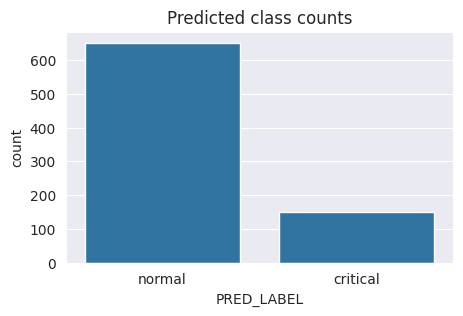

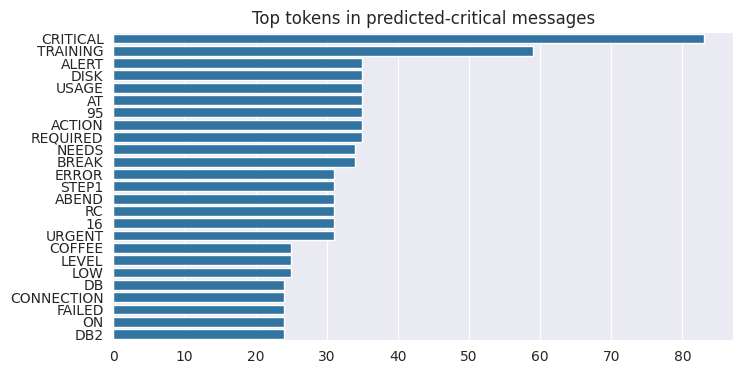

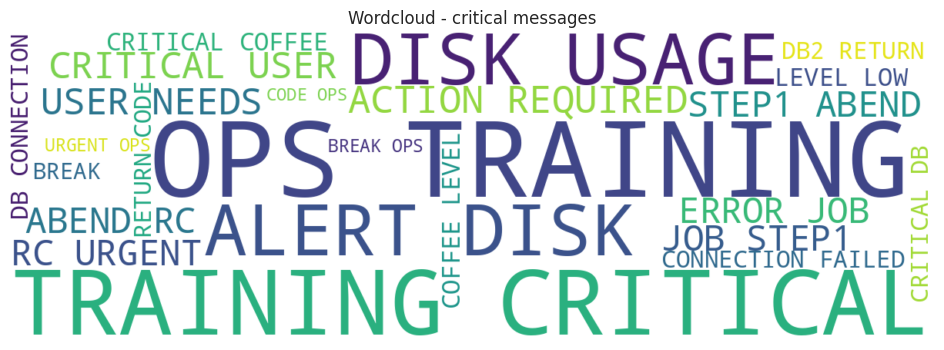

Saved report_msg.html and PNGs.


In [12]:
# Class counts
plt.figure(figsize=(5,3))
sns.countplot(x=df['PRED_LABEL'], order=df['PRED_LABEL'].value_counts().index)
plt.title("Predicted class counts")
plt.savefig("pred_class_counts.png", bbox_inches='tight', dpi=150)
plt.show()

# Top tokens in critical predictions
crit_texts = df.loc[df['PRED_LABEL']=='critical','TEXT'].astype(str).str.upper()
tokens = crit_texts.str.findall(r"[A-Z0-9']+")
all_tokens = list(itertools.chain.from_iterable(tokens))
stop = set(["THE","AND","TO","OF","IN","IS","A","AN","JOB","STEP","USER","MSG","OPS"])
freq = Counter([t for t in all_tokens if t not in stop and len(t)>1])
top = freq.most_common(25)
if top:
    words, counts = zip(*top)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title("Top tokens in predicted-critical messages")
    plt.savefig("top_critical_tokens.png", bbox_inches='tight', dpi=150)
    plt.show()

# Wordcloud
text_concat = " ".join(crit_texts.tolist())
if text_concat.strip():
    wc = WordCloud(width=1200, height=400, background_color='white').generate(text_concat)
    plt.figure(figsize=(12,4)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
    plt.title("Wordcloud - critical messages")
    plt.savefig("wordcloud_critical.png", bbox_inches='tight', dpi=150)
    plt.show()

# Simple HTML report
html = f"""
<html><head><title>MSG Classification Report</title></head><body>
<h1>MSG Table — Quick ML Report</h1>
<p>Rows: {len(df)}</p>
<h2>Class counts</h2><img src='pred_class_counts.png' width=600>
<h2>Top tokens (critical)</h2><img src='top_critical_tokens.png' width=600>
<h2>Wordcloud (critical)</h2><img src='wordcloud_critical.png' width=800>
<h2>Sample predicted-critical messages (top 20)</h2><pre style='font-family: monospace; font-size:12px;'>
{df.loc[df['PRED_LABEL']=='critical', ['SEQNO','TEXT']].head(20).to_string(index=False)}
</pre></body></html>
"""
open("report_msg.html","w").write(html)
print("Saved report_msg.html and PNGs.")

In [16]:
# ==========================
# INSTALL DEPENDENCIES
# ==========================
!pip install -q plotly ipywidgets

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import time
import itertools
from collections import Counter

import ipywidgets as widgets
from IPython.display import display, clear_output

# Firebase already initialized earlier:
# from firebase_admin import firestore
# db = firestore.client()

# ==========================
# FETCH DATA FROM FIRESTORE
# ==========================
def fetch_df(limit=500):
    try:
        docs = (
            db.collection("tbl_msg")
            .order_by("TIMESTMP", direction=firestore.Query.DESCENDING)
            .limit(limit)
            .stream()
        )
    except Exception:
        docs = db.collection("tbl_msg").limit(limit).stream()

    rows = []
    for d in docs:
        r = d.to_dict()
        r["_docid"] = d.id
        rows.append(r)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows)

# ==========================
# UI WIDGETS
# ==========================
limit_w = widgets.IntSlider(
    value=500, min=50, max=2000, step=50, description="Rows:"
)
refresh_btn = widgets.Button(description="Refresh Dashboard")
filter_w = widgets.Dropdown(
    options=["all", "critical", "normal"], value="all", description="Filter:"
)

display(refresh_btn, limit_w, filter_w)

out = widgets.Output()
display(out)

# ==========================
# DASHBOARD RENDERING
# ==========================
def render():
    with out:
        clear_output(wait=True)
        df = fetch_df(limit_w.value)

        if df.empty:
            print("No data found in Firestore.")
            return

        # Normalize label column
        df["LABEL"] = df.get("predicted_label", df.get("LABEL", "")).astype(str).str.lower()

        # Apply filter
        if filter_w.value != "all":
            df = df[df["LABEL"] == filter_w.value]

        # Display the top messages (only show columns that exist)
        display_cols = [c for c in ["SEQNO", "TIMESTMP", "JOBNAME", "MSGID", "USERID", "LABEL", "TEXT"] if c in df.columns]
        display(df[display_cols].head(200))

        # ========= BAR CHART (Counts) =========
        if "LABEL" in df.columns:
            vc = df["LABEL"].value_counts()

            df_vc = vc.reset_index(name="Count")
            df_vc.columns = ["Label", "Count"]

            if not df_vc.empty:
                fig = px.bar(df_vc, x="Label", y="Count", title="Message Classification Counts")
                fig.update_layout(height=350)
                fig.show()

# Button click handler
def on_refresh(b):
    render()

refresh_btn.on_click(on_refresh)

# INITIAL RENDER
render()


Button(description='Refresh Dashboard', style=ButtonStyle())

IntSlider(value=500, description='Rows:', max=2000, min=50, step=50)

Dropdown(description='Filter:', options=('all', 'critical', 'normal'), value='all')

Output()